In [1]:
from datascience import *
import numpy as np

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
%matplotlib inline

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

## Swain v Alabama

What is the probability of getting the actual panel with 8/100 black jurors?

1. Start with the distributions of eligible jurors and the actual panel.
2. Draw panels at random from the eligible jurors.
3. See if my actual panel is likely.

### Step 1: Distributions of population and sample

In [2]:
swain = Table().with_columns(
    'Ethnicity', make_array('Black', 'Other'),
    'Eligible', make_array(0.26, 0.74),
    'Panel', make_array(0.08, 0.92)
)

swain.set_format([1, 2], PercentFormatter(0))

Ethnicity,Eligible,Panel
Black,26%,8%
Other,74%,92%


### Step 2: Draw panels at random from population

In [3]:
population_distribution = swain.column('Eligible')
panel_size = 100

def random_jury_panel():
    panel = swain.select(0).sample(panel_size, weights=swain.column('Eligible'))
    counts = panel.group(0)
    sample_proportions = counts.select(0).with_column('Random', counts.column(1) / panel_size)
    sample_proportions.set_format(1, PercentFormatter(0))
    return swain.join('Ethnicity', sample_proportions)

random_jury_panel()

Ethnicity,Eligible,Panel,Random
Black,26%,8%,22%
Other,74%,92%,78%


### Step 3: See if sample panel is unlikely

In [4]:
def total_variation_distance(distribution_1, distribution_2):
    """Each distribution is an array of proportions that sums to 1."""
    return np.abs(distribution_1 - distribution_2).sum()/2

def table_tvd(table, label_1, label_2):
    return total_variation_distance(table.column(label_1), table.column(label_2))

table_tvd(swain, 'Eligible', 'Panel')

0.18000000000000002

In [5]:
# Compute the empirical distribution of TVDs

tvds = make_array()

for i in np.arange(1000): # Repetitions
    new_sample = random_jury_panel()
    tvds = np.append(tvds, table_tvd(new_sample, 'Eligible', 'Random'))

results = Table().with_column('TVD between the population & a random sample', tvds)
results

TVD between the population & a random sample
0.01
0.05
0.04
0.03
0.04
0.02
0.11
0.03
0.03
0.05


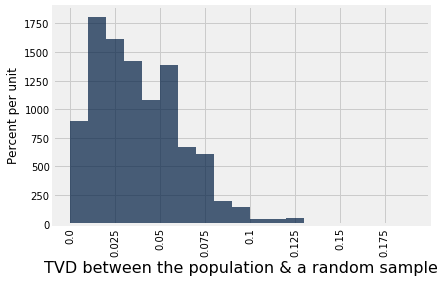

In [6]:
results.hist(bins=np.arange(0, 0.2, 0.01))

In [7]:
table_tvd(swain, 'Eligible', 'Panel')

0.18000000000000002

## Alameda County Juries

### Step 1: Distributions of population and sample

In [8]:
# Data from an ACLU 2010 report
# Racial and Ethnic Disparities in Alameda County Jury Pools
# https://www.aclunc.org/sites/default/files/racial_and_ethnic_disparities_in_alameda_county_jury_pools.pdf

panels = Table().with_columns(
    'Ethnicity', make_array('Asian', 'Black', 'Latino', 'White', 'Other'),
    'Eligible', make_array(0.15, 0.18, 0.12, 0.54, 0.01),
    'Panels', make_array(0.26, 0.08, 0.08, 0.54, 0.04)
)

panels.set_format([1, 2], PercentFormatter(0))

Ethnicity,Eligible,Panels
Asian,15%,26%
Black,18%,8%
Latino,12%,8%
White,54%,54%
Other,1%,4%


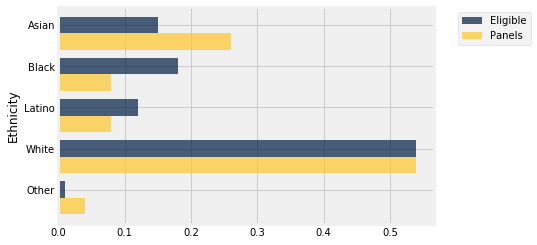

In [9]:
panels.barh(0)

### Step 2: Draw panels at random from population

In [11]:
panel_size = 1453

In [10]:
panels

Ethnicity,Eligible,Panels
Asian,15%,26%
Black,18%,8%
Latino,12%,8%
White,54%,54%
Other,1%,4%


In [15]:
panels.select('Ethnicity').sample(10000).group('Ethnicity')

Ethnicity,count
Asian,1929
Black,1995
Latino,2078
Other,1970
White,2028


In [16]:
panels.column('Eligible')

array([ 0.15,  0.18,  0.12,  0.54,  0.01])

In [18]:
panels.select('Ethnicity').sample(panel_size, weights=panels.column('Eligible')).group('Ethnicity')

Ethnicity,count
Asian,209
Black,248
Latino,175
Other,13
White,808


In [21]:
sample_1 = proportions_from_distribution(panels, 'Eligible', panel_size)
sample_1.set_format([1, 2, 3], PercentFormatter(0))

Ethnicity,Eligible,Panels,Random Sample
Asian,15%,26%,16%
Black,18%,8%,18%
Latino,12%,8%,12%
White,54%,54%,53%
Other,1%,4%,1%


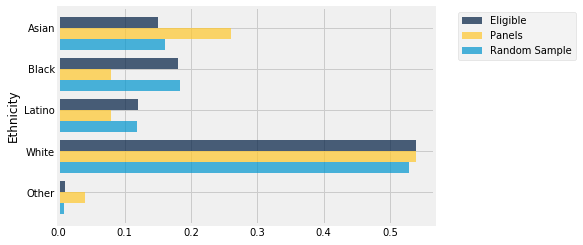

In [22]:
sample_1.barh(0)

### Step 3: See if sample panel is unlikely

In [23]:
table_tvd(sample_1, 'Eligible', 'Random Sample')

0.013427391603578807

In [36]:
panel_size = 1453
repetitions = 1000
tvds = make_array()

for i in np.arange(repetitions):
    sample = proportions_from_distribution(panels, 'Eligible', panel_size)
    tvds = np.append(tvds, table_tvd(sample, 'Eligible', 'Random Sample'))

results = Table().with_columns('TVD between population and random sample', tvds)
results

TVD between population and random sample
0.0232897
0.0192361
0.0148245
0.02351
0.00993118
0.0104267
0.0113076
0.0217275
0.0135031
0.00391604


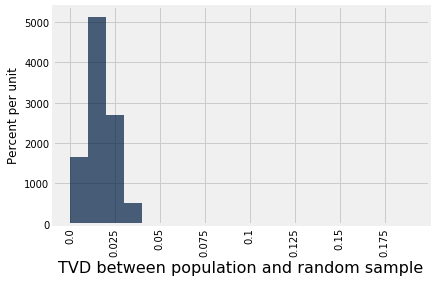

In [27]:
results.hist(0, bins=np.arange(0, 0.2, 0.01))

In [28]:
def hist_n_samples(tbl, n, bins=None):
    '''Draws histogram of first n rows of first column in tbl.'''
    tbl.take(np.arange(n)).hist(bins=bins)
    plt.ylim(0, 50)
    plt.show()

In [29]:
_ = interact(hist_n_samples, tbl=fixed(results), n=(1, 1000, 10), bins=fixed(np.arange(0, 0.2, 0.01)))

/srv/app/venv/lib/python3.5/site-packages/traitlets/traitlets.py:567: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  silent = bool(old_value == new_value)


In [31]:
table_tvd(panels, 'Eligible', 'Panels')

0.14000000000000001

In [32]:
panels

Ethnicity,Eligible,Panels
Asian,15%,26%
Black,18%,8%
Latino,12%,8%
White,54%,54%
Other,1%,4%


Discussion question: How do you think our analysis would change if the jury panels had only 50 people?

In [37]:
panel_size = 50
repetitions = 1000
tvds = make_array()

for i in np.arange(repetitions):
    sample = proportions_from_distribution(panels, 'Eligible', panel_size)
    tvds = np.append(tvds, table_tvd(sample, 'Eligible', 'Random Sample'))

results_50 = Table().with_columns('TVD between population and random sample', tvds)
results_50

TVD between population and random sample
0.12
0.02
0.09
0.06
0.06
0.12
0.13
0.18
0.07
0.08


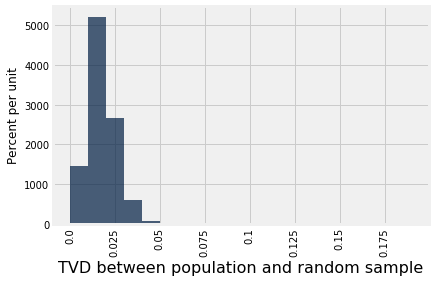

In [40]:
results.hist(0, bins=np.arange(0, 0.2, 0.01))

In [38]:
_ = interact(hist_n_samples, tbl=fixed(results_50), n=(1, 1000, 10), bins=fixed(np.arange(0, 0.2, 0.01)))

/srv/app/venv/lib/python3.5/site-packages/traitlets/traitlets.py:567: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  silent = bool(old_value == new_value)


## Addendum: Alameda County Race & Ethnicity Distribution

In [41]:
# According to the 2010 Census, https://www.census.gov/2010census/popmap/

alameda_race = Table(['Race', 'Population']).with_rows([
    ['White', 649122],
    ['African American', 190451],
    ['Asian', 394560],
    ['AIAN', 9799],
    ['NHPI', 12802],
    ['Some Other Race', 162540],
    ['Two or more Races', 90997],
])

alameda_race.set_format(1, DistributionFormatter).show()

alameda_ethnicity = Table(['Ethnicity', 'Population']).with_rows([
    ['Hispanic or Latino', 339889],
    ['Not Hispanic or Latino', 1170382],
])

alameda_ethnicity.set_format(1, DistributionFormatter).show()

Race,Population
White,42.98%
African American,12.61%
Asian,26.13%
AIAN,0.65%
NHPI,0.85%
Some Other Race,10.76%
Two or more Races,6.03%


Ethnicity,Population
Hispanic or Latino,22.51%
Not Hispanic or Latino,77.49%


In [42]:
panels

Ethnicity,Eligible,Panels
Asian,15%,26%
Black,18%,8%
Latino,12%,8%
White,54%,54%
Other,1%,4%
